# Imports & Settings

In [1]:
import numpy as np
import sympy as sp
from matplotlib import pyplot as plt
from matplotlib.patches import *
import pandas as pd
from IPython.display import display, Math
from Lagrange import LagrangeSym as Lagrange
from functions import *


In [2]:
x = sp.symbols('x')

funcExpr = sp.cos(x);
original = sp.lambdify(x, funcExpr, 'numpy')
start = 0
end = np.pi/2
xSpace = np.linspace(0, 1.75, 100, dtype=float)
ySpace = original(xSpace)
print("Оригинальная функция:")
funcExpr

Оригинальная функция:


cos(x)

<>:14: SyntaxWarning: invalid escape sequence '\i'
<>:14: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_14109/3679644631.py:14: SyntaxWarning: invalid escape sequence '\i'
  text = "\int^{\pi / 2}_0cos(x)dx = 1"


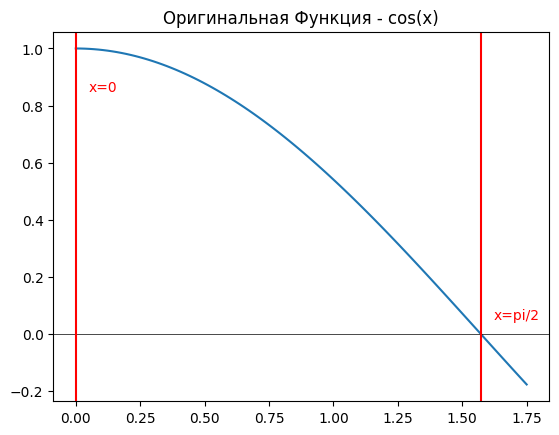

<IPython.core.display.Math object>

In [3]:
plt.title('Оригинальная Функция - cos(x)')

# plt.fill_between(xSpace, y, np.zeros_like(xSpace))
plt.plot(xSpace, ySpace)
plt.axhline(0, color='black', linewidth=0.5)

plt.axvline(start, color='red',)
plt.axvline(end, color='red')

plt.text(.05, .85, 'x=0', color='red')
plt.text(end + .05, .05, 'x=pi/2', color='red')
plt.show()

text = "\int^{\pi / 2}_0cos(x)dx = 1"
display(Math(text))

## Формулы Прямоугольников

Левых прямоугольников:

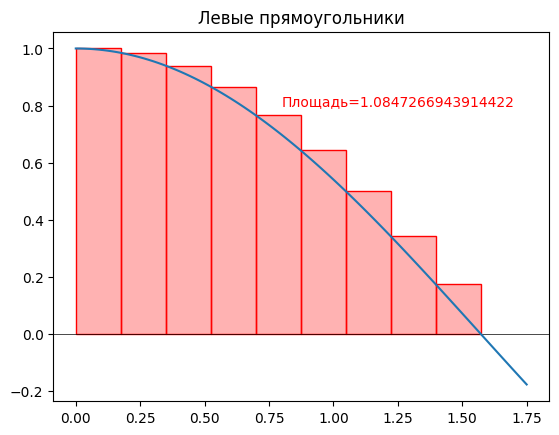

1.0847266943914422


In [4]:
fig, ax = plt.subplots()
ax.set_title('Левые прямоугольники')
ax.axhline(0, color='black', linewidth=0.5)
ax.plot(xSpace, ySpace)
points = 10 # Количество точек в полуинтервале [start, end)

xRange = np.linspace(start, end, points)

y = original(xRange)
# print(xRange, y)

ApproxSum = 0
for i in range(points-1):
    h = xRange[i+1] - xRange[i]
    ax.add_patch(Rectangle([xRange[i],0], h, y[i], facecolor=('r', .3), edgecolor='r',))
    ApproxSum += h * y[i]

plt.text(.8, .8, 'Площадь=' + str(ApproxSum), color='r')
plt.show()
print(ApproxSum)

Правые Прямоугольники:

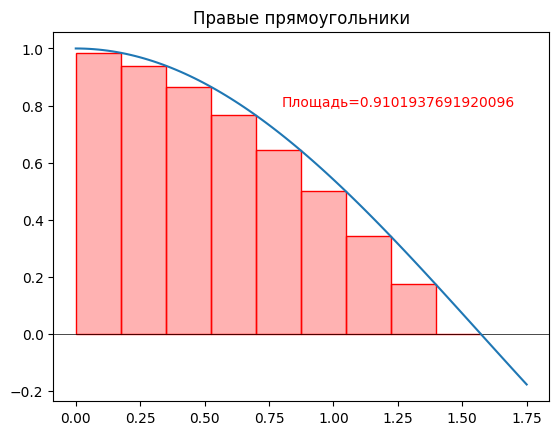

0.9101937691920096


In [5]:
fig, ax = plt.subplots()
ax.set_title('Правые прямоугольники')
ax.axhline(0, color='black', linewidth=0.5)
ax.plot(xSpace, ySpace)
points = 10 # Количество точек в полуинтервале [start, end)

xRange = np.linspace(start, end, points)

y = original(xRange)

ApproxSum = 0
for i in range(1, points):
    h = xRange[i] - xRange[i-1]
    ax.add_patch(Rectangle([xRange[i],0], -h, y[i], facecolor=('r', .3), edgecolor='r',))
    ApproxSum += h * y[i]

plt.text(.8, .8, 'Площадь=' + str(ApproxSum), color='r')
plt.show()
print(ApproxSum)

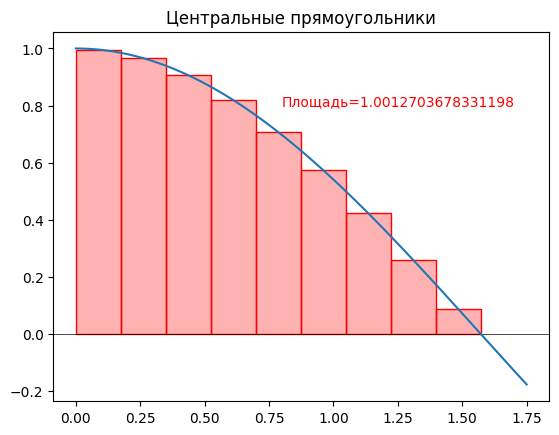

1.0012703678331198


In [105]:
fig, ax = plt.subplots()
ax.set_title('Центральные прямоугольники')
ax.axhline(0, color='black', linewidth=0.5)
ax.plot(xSpace, ySpace)
points = 10 # Количество точек в полуинтервале [start, end)

xRangeLeft = np.linspace(start, end, points)
xRange = (xRangeLeft[:-1] + xRangeLeft[1:]) / 2 
y = original(xRange)

ApproxSum = 0
for i in range(points-1):
    h = xRangeLeft[1] - xRangeLeft[0]
    ax.add_patch(Rectangle([xRangeLeft[i],0], h, y[i], facecolor=('r', .3), edgecolor='r',))
    ApproxSum += h * y[i]

plt.text(.8, .8, 'Площадь=' + str(ApproxSum), color='r')
plt.show()
print(ApproxSum)

## Формулы Трапеций, Симпсона и Веддля

Формула Трапеций

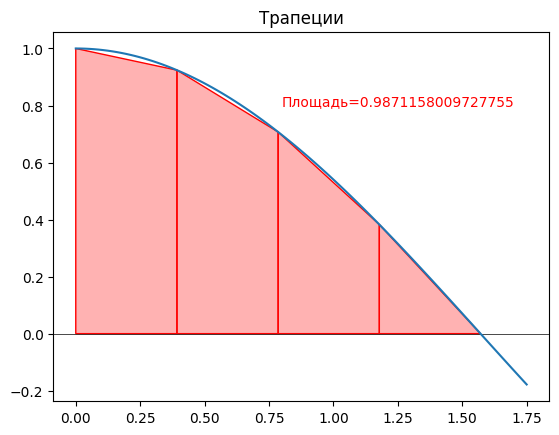

0.9871158009727755


In [62]:
fig, ax = plt.subplots()
ax.set_title('Трапеции')
ax.axhline(0, color='black', linewidth=0.5)
ax.plot(xSpace, ySpace)

points = 5
xRange = np.linspace(start, end, points)
y = original(xRange)

ApproxSum = 0
for i in range(points-1):
    h = xRange[i+1] - xRange[i]
    ApproxSum += h * (y[i] + y[i+1]) / 2
    ax.fill([xRange[i], xRange[i], xRange[i+1], xRange[i+1]], [0, y[i], y[i+1], 0], color=('r', .3), edgecolor='r')

plt.text(.8, .8, 'Площадь=' + str(ApproxSum), color='r')
plt.show()
print(ApproxSum)

Метод Симпсона:

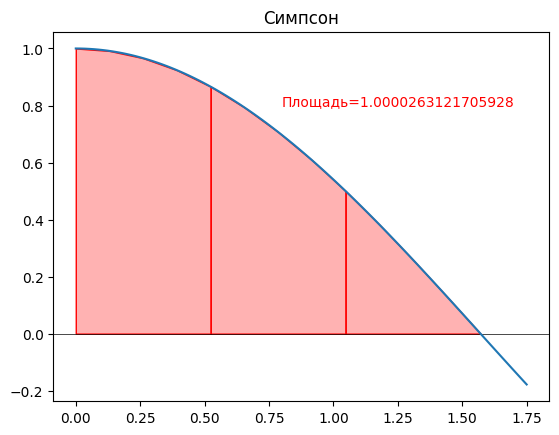

1.0000263121705928


In [104]:
fig, ax = plt.subplots()
ax.set_title('Симпсон')
ax.axhline(0, color='black', linewidth=0.5)
ax.plot(xSpace, ySpace)

parabols = 3

xRange = np.linspace(start, end, 1 + 2*parabols)
y = original(xRange)

ApproxSum = 0

for i in range(0, len(xRange)-2, 2):
    h = xRange[i+1] - xRange[i]
    ApproxSum += h/3 * (y[i] + 4*y[i+1] + y[i+2])
    
    parabola = sp.lambdify(x, Lagrange(xRange, y, xRange[1] - xRange[0]), 'numpy')
    parSpace = np.linspace(xRange[i], xRange[i+2], 5)
    ax.fill_between(parSpace, parabola(parSpace), color=('r', 0.3), edgecolor='r')

plt.text(.8, .8, 'Площадь=' + str(ApproxSum), color='r')
plt.show()
print(ApproxSum)

Метод Веддля (Weddle's Rule):

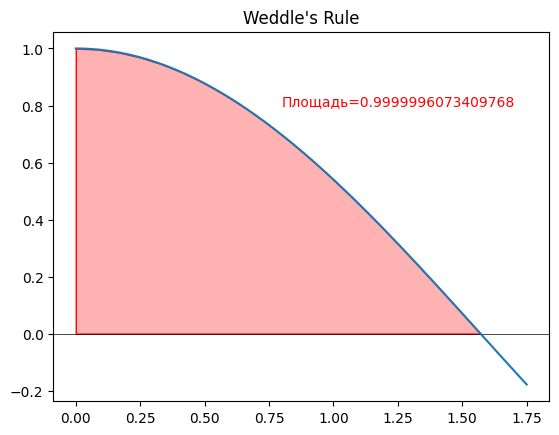

0.9999996073409768


In [9]:
fig, ax = plt.subplots()
ax.set_title("Weddle's Rule")
ax.axhline(0, color='black', linewidth=0.5)
ax.plot(xSpace, ySpace)

n = 1

xRange = np.linspace(start, end, 1 + 6*n)
y = original(xRange)

ApproxSum = 0

for i in range(0, len(xRange)-6, 6):
    h = xRange[i+1] - xRange[i]
    ApproxSum += 0.3 * h * (y[i] + 5*y[i+1] + y[i+2] + 6*y[i+3] + y[i+4] + 5*y[i+5] + y[i+6])
    
    parabola = sp.lambdify(x, Lagrange(xRange, y, xRange[1] - xRange[0]), 'numpy')
    parSpace = np.linspace(xRange[i], xRange[i+6], 20)
    ax.fill_between(parSpace, parabola(parSpace), color=('r', 0.3), edgecolor='r')

plt.text(.8, .8, 'Площадь=' + str(ApproxSum), color='r')
plt.show()
print(ApproxSum)

## Формулы Ньютона-Котеса

In [10]:
c_k_values = [
    [1/2, 1/2],
    [1/6, 4/6, 1/6],
    [1/8, 3/8, 3/8, 1/8],
    [7/90, 32/90, 12/90, 32/90, 7/90],
    [19/288, 75/288, 50/288, 50/288, 75/288, 19/288],
    [41/840, 216/840, 27/840, 272/840, 27/840, 216/840, 41/840]
]



for i in c_k_values:
    ApproxSum = 0
    xRange = np.linspace(start, end, len(i))
    y = original(xRange)

    for j in range(len(i)):
        # h = xRange[j+1] - xRange[j]
        ApproxSum += (end-start) * i[j]*y[j]

    print('Площадь:', ApproxSum, 'n =', len(i)-1)

Площадь: 0.7853981633974483 n = 1
Площадь: 1.0022798774922104 n = 2
Площадь: 1.001004923314279 n = 3
Площадь: 0.999991565472993 n = 4
Площадь: 0.9999952613861668 n = 5
Площадь: 1.0000000258372352 n = 6


## Формулы Гаусса

In [11]:
nodes_t = [
    np.array([0.0]),
    np.array([-0.577350, 0.577350]),
    np.array([-0.774597, 0.0, 0.774597]),
    np.array([-0.861136, -0.339981, 0.339981, 0.861136])
]

weights_c = [
    [2.0],
    [1.0, 1.0],
    [5.0/9.0, 8.0/9.0, 5.0/9.0], 
    [0.347855, 0.652145, 0.652145, 0.347855]
]



for i, nodes in enumerate(nodes_t):
    ApproxSum = 0
    y = original(nodes*(end-start)/2 + (end+start)/2)

    for j in range(len(nodes)):
        ApproxSum += (end-start)/2 * y[j]*weights_c[i][j]

    print('Площадь:', ApproxSum, 'n =', len(nodes))

Площадь: 1.1107207345395915 n = 1
Площадь: 0.9984727162757971 n = 2
Площадь: 1.000008029939584 n = 3
Площадь: 1.0000000111567542 n = 4


## Расчет оптимальной плотности сетки для заданной точности

In [ ]:
method = Simpson
Err = 0.0000001
n = 1


first = method(start, end, n, original)
second = method(start, end, 2*n, original)
while abs(second - first) > Err:
    n *= 2
    first = second
    second = method(start, end, 2*n, original)

print(n*2, first, second)


16 1.0000005166847064 1.000000032265001
